# 3. Individual glacier surface velocity analysis

This notebook will build upon the data access and inspection steps in the earlier notebooks and demonstrate basic data analysis and visualization of surface velocity data at the scale of an individual glacier using xarray. 

## Learning goals

### Concepts
- Visualizing statistical distributions
- Vectorized calculation of summary statistics over large dimensions
- Working with velocity component vectors
- Calculating magnitude of displacement from velocity component vectors
### Techniques
- Using [`xr.reduce()`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.reduce.html) to apply [scipy statistical functions](https://docs.scipy.org/doc/scipy/reference/stats.html) designed to ingest numpy arrays to Xarray objects
- Re-organize Xarray objects using [`xr.sortby()`](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.sortby.html)
- Temporal resampling using [`xr.resample()`](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.resample.html)
- Vectorized computation and reductions using [`xr.groupby()`](https://docs.xarray.dev/en/stable/user-guide/groupby.html) and [`xr.map()`](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.map.html)
- Visualization using [`FacetGrid`](https://docs.xarray.dev/en/latest/generated/xarray.plot.FacetGrid.html) objects

### Other useful resources
These are resources that contain additional examples and discussion of the content in this notebook and more.
- [Xarray user guide](https://docs.xarray.dev/en/stable/user-guide/index.html)
- [How do I...](https://docs.xarray.dev/en/stable/howdoi.html) this is **very** helpful!
- [Xarray High-level computational patterns](https://tutorial.xarray.dev/intermediate/01-high-level-computation-patterns.html) discussion of concepts and associated code examples
- [Parallel computing with dask](https://tutorial.xarray.dev/intermediate/xarray_and_dask.html) Xarray tutorial demonstrating wrapping of dask arrays

## Software + Setup

In [1]:
%xmode minimal

Exception reporting mode: Minimal


In [2]:
import json
import os
import urllib.request

import flox
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rioxarray as rxr
import scipy
import xarray as xr
from shapely.geometry import Point, Polygon

%config InlineBackend.figure_format='retina'

## Read in clipped glacier velocity object from previous notebook

In the last notebook, we used the [`storemagic`](https://ipython.readthedocs.io/en/stable/config/extensions/storemagic.html) ipython extension to store the object we created. We'll read it in here rather than go through the steps of creating it again. Now that we have the velocity data clipped to a single glacier, let's explore the clipped dataset.

In [3]:
%store -r sample_glacier_raster

In [4]:
sample_glacier_raster

<xarray.Dataset>
Dimensions:                     (mid_date: 3974, y: 37, x: 40)
Coordinates:
  * mid_date                    (mid_date) datetime64[ns] 2018-04-14T04:18:49...
  * x                           (x) float64 7.843e+05 7.844e+05 ... 7.889e+05
  * y                           (y) float64 3.316e+06 3.316e+06 ... 3.311e+06
    mapping                     int64 0
Data variables: (12/60)
    M11                         (mid_date, y, x) float32 nan nan nan ... nan nan
    M11_dr_to_vr_factor         (mid_date) float32 nan nan nan ... nan nan nan
    M12                         (mid_date, y, x) float32 nan nan nan ... nan nan
    M12_dr_to_vr_factor         (mid_date) float32 nan nan nan ... nan nan nan
    acquisition_date_img1       (mid_date) datetime64[ns] 2017-12-20T04:21:49...
    acquisition_date_img2       (mid_date) datetime64[ns] 2018-08-07T04:15:49...
    ...                          ...
    vy_error_slow               (mid_date) float32 8.0 1.7 1.2 ... 9.7 11.3 25.4
    vy_error_stationary         (mid_date) float32 8.0 1.7 1.2 ... 9.7 11.3 25.4
    vy_stable_shift             (mid_date) float32 8.9 -4.9 -0.7 ... -3.6 -10.8
    vy_stable_shift_slow        (mid_date) float32 8.9 -4.9 -0.7 ... -3.6 -10.7
    vy_stable_shift_stationary  (mid_date) float32 8.9 -4.9 -0.7 ... -3.6 -10.8
    cov                         (mid_date) float64 0.3522 0.0 0.0 ... 0.0 0.0
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               25-Sep-2023 22:00:23
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

## Visualize and examine distributions of different variables

Let's first take a look at the velocity components and magnitude of velocity. Plotting a histogram of `vx`, `vy`, and `v` we see that they both have Gaussian distributions. In contrast, magnitude of velocity is positively skewed. The distribution of magnitude of velocity follows a Rician distribution. Because magnitude of velocity is the norm of the two normally-distributed variables (`vx` and `vy`) it follows a Rician distribution. To avoid propagating noise in the dataset, we will work primarily with velocity component variables and calculate the magnitude of velocity after reductions have been performed. 

To construct these plots, we use a combination of xarray plotting functionality and matplotlib object-oriented plotting

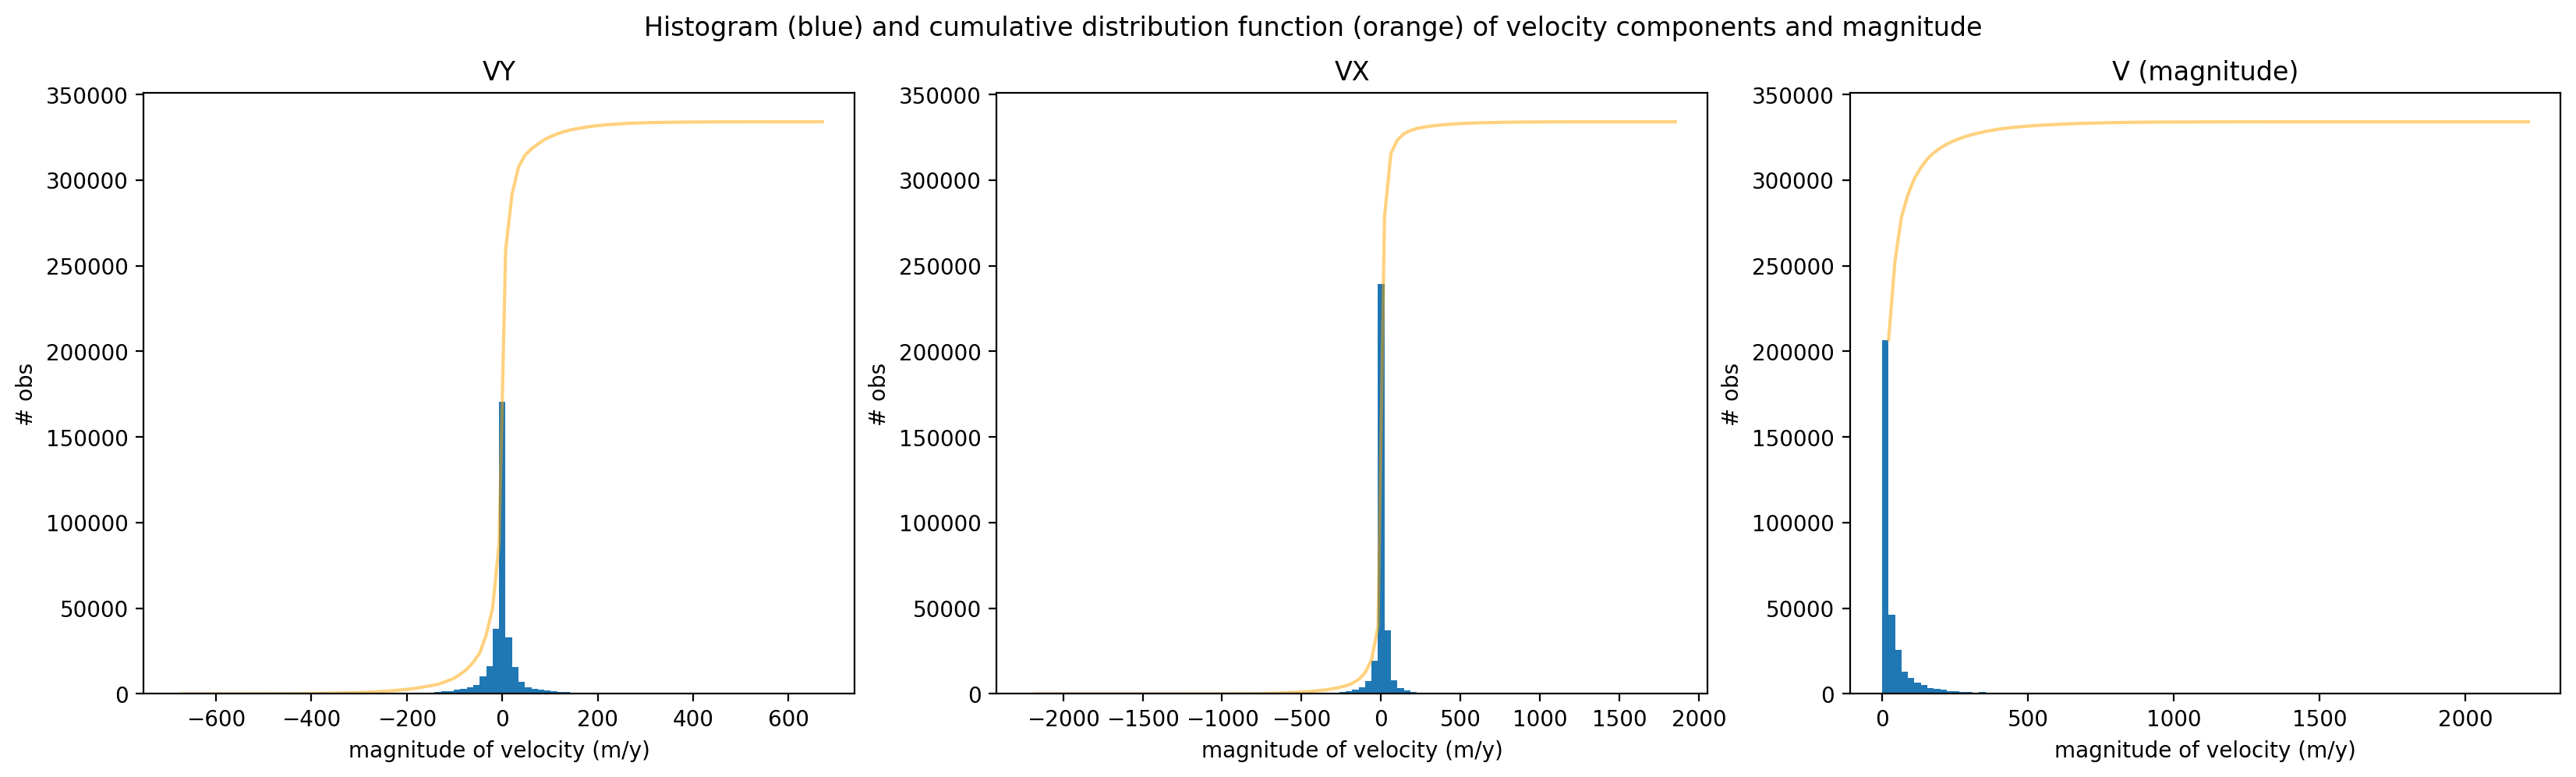

In [5]:
fig,axs=plt.subplots(ncols=3, figsize=(20,5))
hist_y = sample_glacier_raster.vy.plot.hist(ax=axs[0], bins=100)
cumulative_y = np.cumsum(hist_y[0])
axs[0].plot(hist_y[1][1:], cumulative_y, color='orange', linestyle='-', alpha=0.5)

hist_x = sample_glacier_raster.vx.plot.hist(ax=axs[1], bins=100)
cumulative_x = np.cumsum(hist_x[0])
axs[1].plot(hist_x[1][1:], cumulative_x, color='orange', linestyle='-', alpha=0.5)

hist_v = sample_glacier_raster.v.plot.hist(ax=axs[2], bins=100)
cumulative_v = np.cumsum(hist_v[0])
axs[2].plot(hist_v[1][1:], cumulative_v, color='orange', linestyle='-', alpha=0.5)


axs[0].set_title('VY')
axs[1].set_title('VX')
axs[2].set_title('V (magnitude)')

#axs[0].set_xlim(0,50)
#axs[1].set_xlim(0,400)
axs[0].set_ylabel('# obs')
axs[1].set_ylabel('# obs')
axs[2].set_ylabel('# obs')

axs[0].set_xlabel('magnitude of velocity (m/y)')
axs[1].set_xlabel('magnitude of velocity (m/y)')
axs[2].set_xlabel('magnitude of velocity (m/y)')
fig.suptitle('Histogram (blue) and cumulative distribution function (orange) of velocity components and magnitude');

We can also look at the skew of each variable. TO do this, we use `xr.reduce()` and `scipy.stats.skew()`

In [6]:
print('Skew of vy: ',sample_glacier_raster.vy.reduce(func=scipy.stats.skew, nan_policy='omit', dim=['x','y','mid_date']).data)
print('Skew of vx: ',sample_glacier_raster.vx.reduce(func=scipy.stats.skew, nan_policy='omit', dim=['x','y','mid_date']).data)
print('Skew of v: ',sample_glacier_raster.v.reduce(func=scipy.stats.skew, nan_policy='omit', dim=['x','y','mid_date']).data)

Skew of vy:  -0.4540084857562447
Skew of vx:  0.19356243875503296
Skew of v:  5.005839671572479


## Calculating magnitude of velocity 

We'll first define a function for calculating magnitude of velocity in two ways. Because we want to calculate the magnitude of the displacement vector after we have already reduced the data along a dimension, we write a function that creates two magnitude of velocity variables, one where magnitude is calculated from the means of the vx and vy vectors in space and one where the magnitude is calculated from the medians of the vx and vy vectors in time. We just need to be careful which variable we use. 



In [7]:
def calc_velocity_magnitude(ds):
    #naming convention is the dim that variable still has 
    # use mean for reductions of components because components normally distributed
    ds = ds.copy()
    
    ds['v_mag_time'] = np.sqrt(ds.vx.mean(dim=['x','y'])**2 + ds.vy.mean(dim=['x','y'])**2)

    ds['v_mag_space'] = np.sqrt(ds.vx.mean(dim=['mid_date'])**2 + (ds.vy.mean(dim=['mid_date'])**2))
    return ds

In [8]:
sample_glacier_raster_mag = calc_velocity_magnitude(sample_glacier_raster)

### Visualize velocity variability 

Now that we have calculated magnitude of velocity, we will plot the histogram of calculated magnitude of velocity values in space (left) and time (right). Note that the scales of the x-axes of the two plots are different, as are the number of bins used in each. These results indicate that the variability of velocity in time is much greater than the variability of velocity in space.

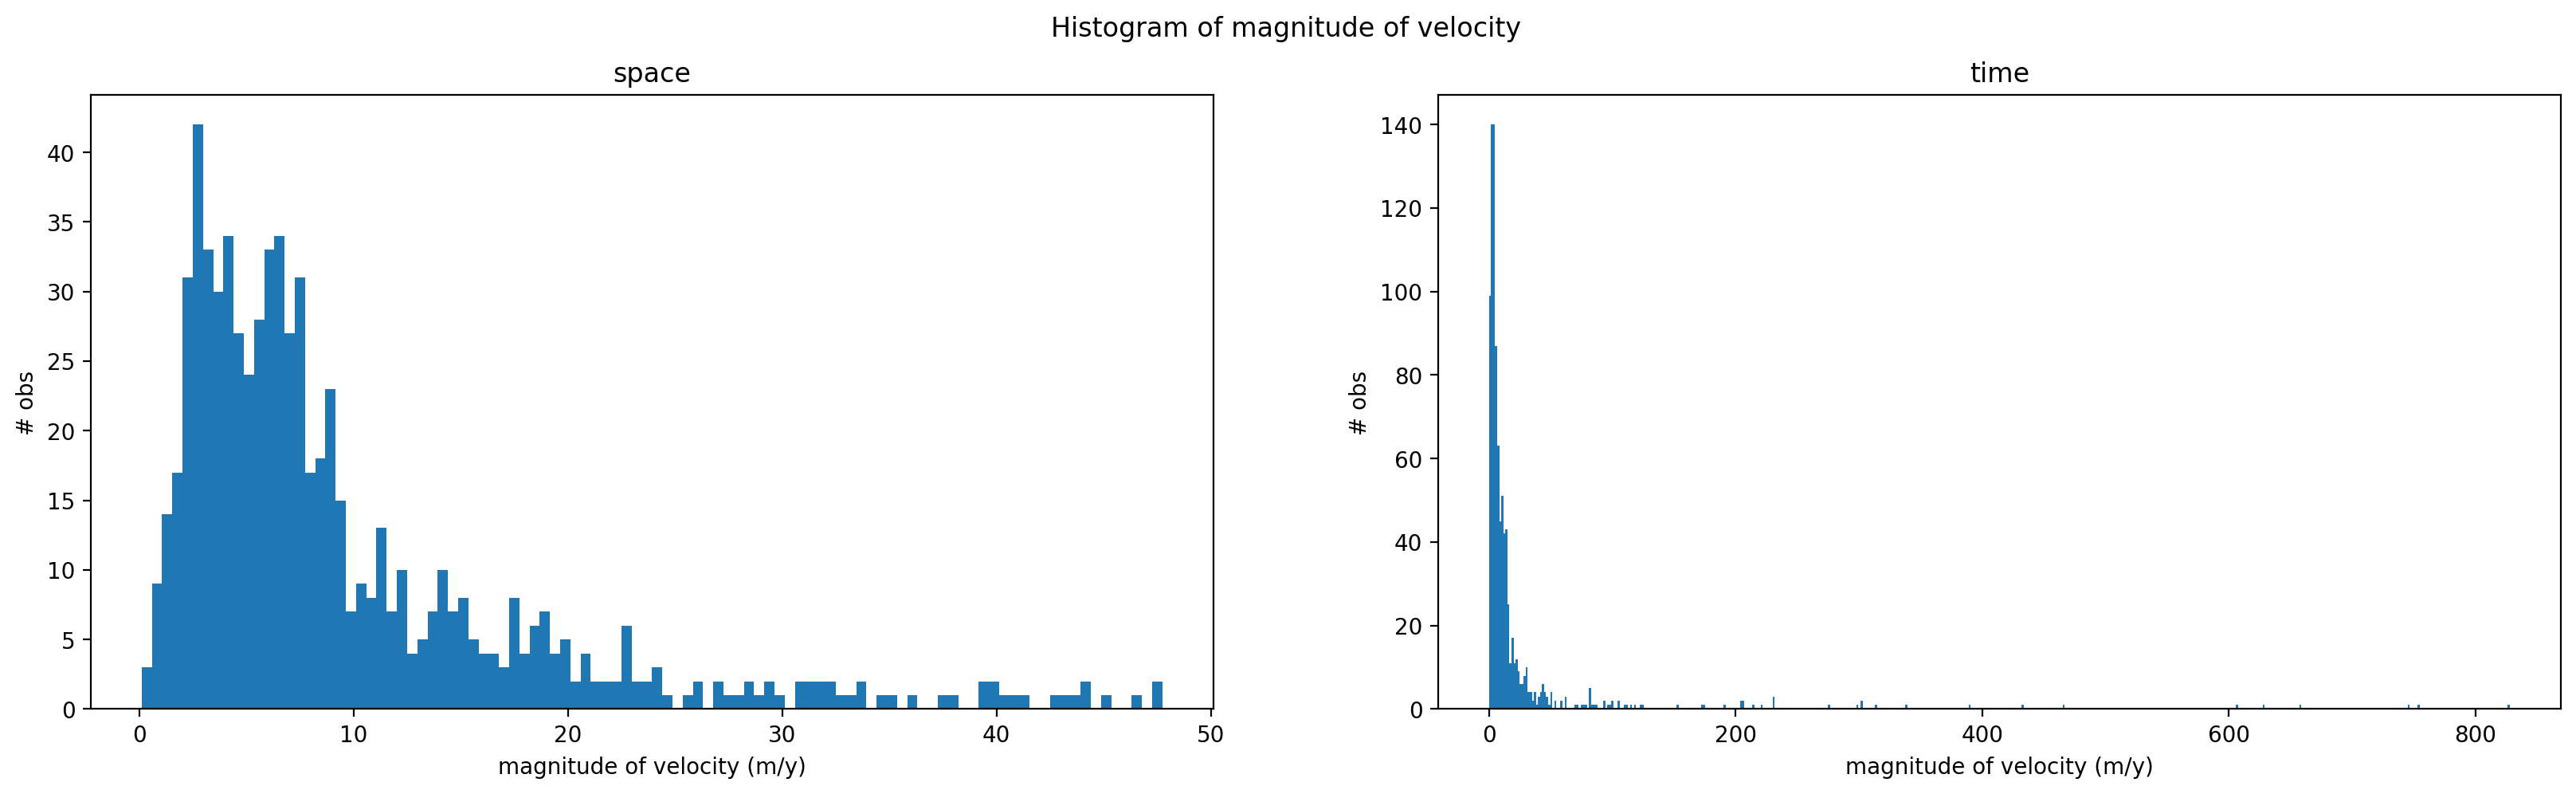

In [9]:
fig,axs=plt.subplots(ncols=2, figsize=(20,5))
sample_glacier_raster_mag.v_mag_space.plot.hist(ax=axs[0], bins=100)
sample_glacier_raster_mag.v_mag_time.plot.hist(ax=axs[1], bins=500)
axs[0].set_title('space')
axs[1].set_title('time')

#axs[0].set_xlim(0,60)
#axs[1].set_xlim(0,400)

axs[0].set_ylabel('# obs')
axs[1].set_ylabel('# obs')
axs[0].set_xlabel('magnitude of velocity (m/y)')
axs[1].set_xlabel('magnitude of velocity (m/y)')

fig.suptitle('Histogram of magnitude of velocity'); 

We can look at skewness of the magnitude distributions to better understand how these variables behave in space and time.

In [10]:
print('Skew of vmag reduced along spatial dimensions: ',sample_glacier_raster_mag.v_mag_time.reduce(func=scipy.stats.skew, nan_policy='omit', dim=['mid_date']).data)
print('Skew of vmag reduced along temporal dimension: ',sample_glacier_raster_mag.v_mag_space.reduce(func=scipy.stats.skew, nan_policy='omit', dim=['x','y',]).data)

Skew of vmag reduced along spatial dimensions:  7.368324621443265
Skew of vmag reduced along temporal dimension:  2.0117210137206567


Both `v_mag_time` (reduced along spatial dimensions, exists along temporal dimension) and `v_mag_space` (reduced along temporal dimension, exists along spatial dimensions) are positively skewed. We also see that the skewness `v_mag_time` is much greater than `v_mag_space`, suggesting that the distribution of magnitude of velocity is much more positively skewed (characterized by large, positive outliers) in time than in space. Physically speaking, magnitude of velocity variability is characterized by more extreme outliers over time than across the surface of the glacier. 


### Checking coverage
Now that we've reduced the dataset, we can look at the coverage of the magnitude variables using xarray methods.
First, we want to know how many observations (not NaNs) exist along the time dimension of `v_mag_time`. We can use `xr.DataArray.count()`:

In [11]:
sample_glacier_raster_mag.v_mag_time.count(dim='mid_date').data

array(927)

We can verify that by using `isnull()`, `notnull()` and `sum()`:

In [12]:
sample_glacier_raster_mag.v_mag_time.isnull().sum().data

array(3047)

In [13]:
sample_glacier_raster_mag.v_mag_time.notnull().sum().data

array(927)

Great, now look at space:

In [14]:
sample_glacier_raster_mag.v_mag_space.count(dim=['x','y']).data

array(707)

And checking against the `sum()` methods:

In [15]:
sample_glacier_raster_mag.v_mag_space.isnull().sum().data

array(773)

In [16]:
sample_glacier_raster_mag.v_mag_space.notnull().sum().data

array(707)

Next, we will visualize magnitude of velocity calculated by reducing along the x and y dimensions:

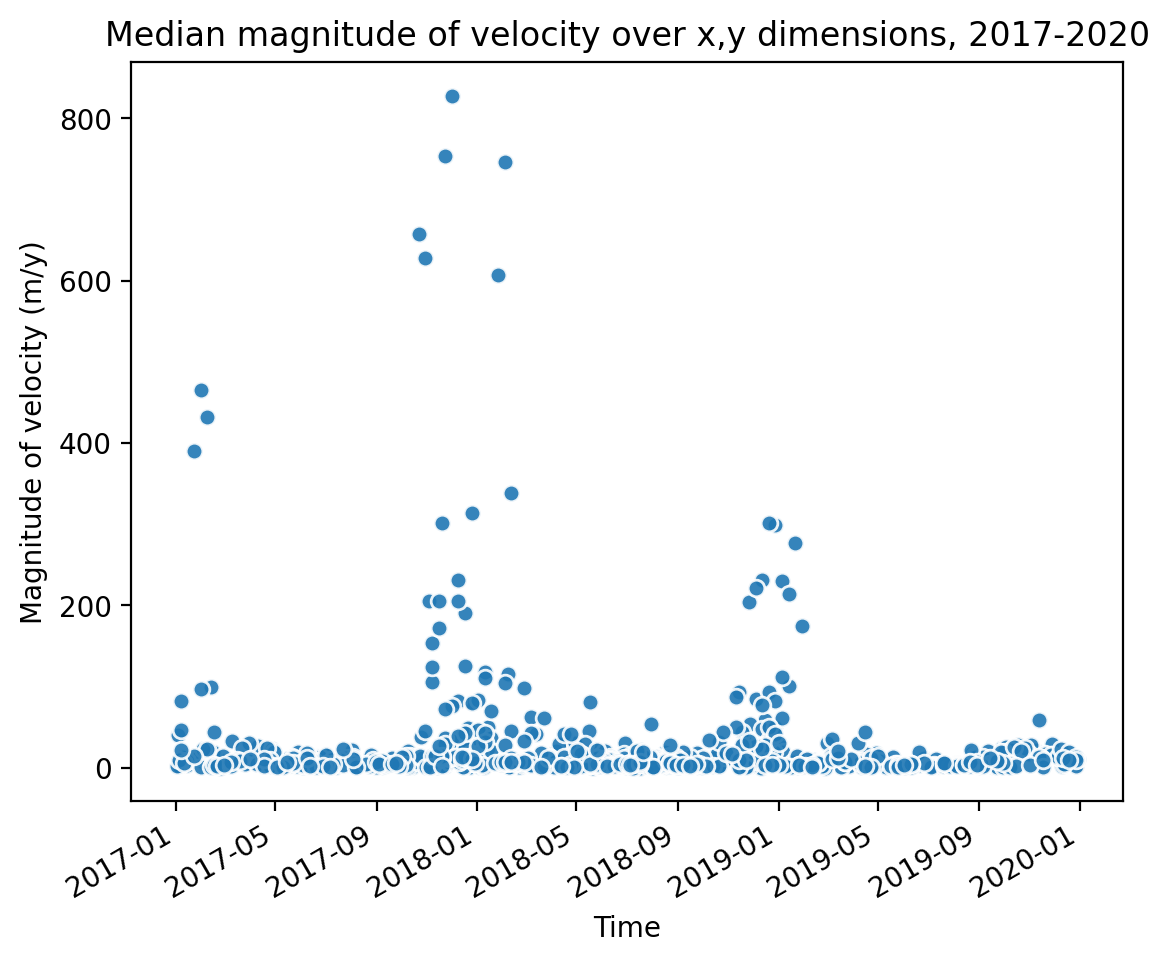

In [17]:
fig, ax= plt.subplots()
sample_glacier_raster_mag['v_mag_time'].plot.scatter(marker='o', alpha=0.9)
ax.set_title('Median magnitude of velocity over x,y dimensions, 2017-2020')
ax.set_ylabel('Magnitude of velocity (m/y)')
ax.set_xlabel('Time');

## Temporal resampling

Similar to the histogram, the time series shows a large amount of variability in median velocity over time. Let's use xarray tools to resample the time dimension.

In [18]:
sample_glacier_raster = sample_glacier_raster.sortby('mid_date')

In [19]:
sample_glacier_raster

<xarray.Dataset>
Dimensions:                     (mid_date: 3974, y: 37, x: 40)
Coordinates:
  * mid_date                    (mid_date) datetime64[ns] 2017-01-01T16:15:50...
  * x                           (x) float64 7.843e+05 7.844e+05 ... 7.889e+05
  * y                           (y) float64 3.316e+06 3.316e+06 ... 3.311e+06
    mapping                     int64 0
Data variables: (12/60)
    M11                         (mid_date, y, x) float32 nan nan nan ... nan nan
    M11_dr_to_vr_factor         (mid_date) float32 nan nan nan ... nan nan nan
    M12                         (mid_date, y, x) float32 nan nan nan ... nan nan
    M12_dr_to_vr_factor         (mid_date) float32 nan nan nan ... nan nan nan
    acquisition_date_img1       (mid_date) datetime64[ns] 2016-05-24T04:15:52...
    acquisition_date_img2       (mid_date) datetime64[ns] 2017-08-12T04:15:49...
    ...                          ...
    vy_error_slow               (mid_date) float32 2.5 2.7 3.1 ... 4.6 1.6 11.3
    vy_error_stationary         (mid_date) float32 2.5 2.7 3.1 ... 4.6 1.6 11.2
    vy_stable_shift             (mid_date) float32 -7.7 -13.0 -2.5 ... 3.3 -7.6
    vy_stable_shift_slow        (mid_date) float32 -7.7 -12.9 -2.5 ... 3.3 -7.6
    vy_stable_shift_stationary  (mid_date) float32 -7.7 -13.0 -2.5 ... 3.3 -7.6
    cov                         (mid_date) float64 0.0 0.0 0.2489 ... 0.0 0.9562
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               25-Sep-2023 22:00:23
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

In [20]:
resample_obj = sample_glacier_raster.resample(mid_date = '1M')

[`xr.resample()`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.resample.html) is another grouping operation and returns an object of type `xarray.core.resample.DatasetResample`

In [21]:
glacier_resample_1mo = resample_obj.median(dim='mid_date')

The below plot is the initial velocity time series in blue, and the velocity data resampled to 1 month intervals in orange

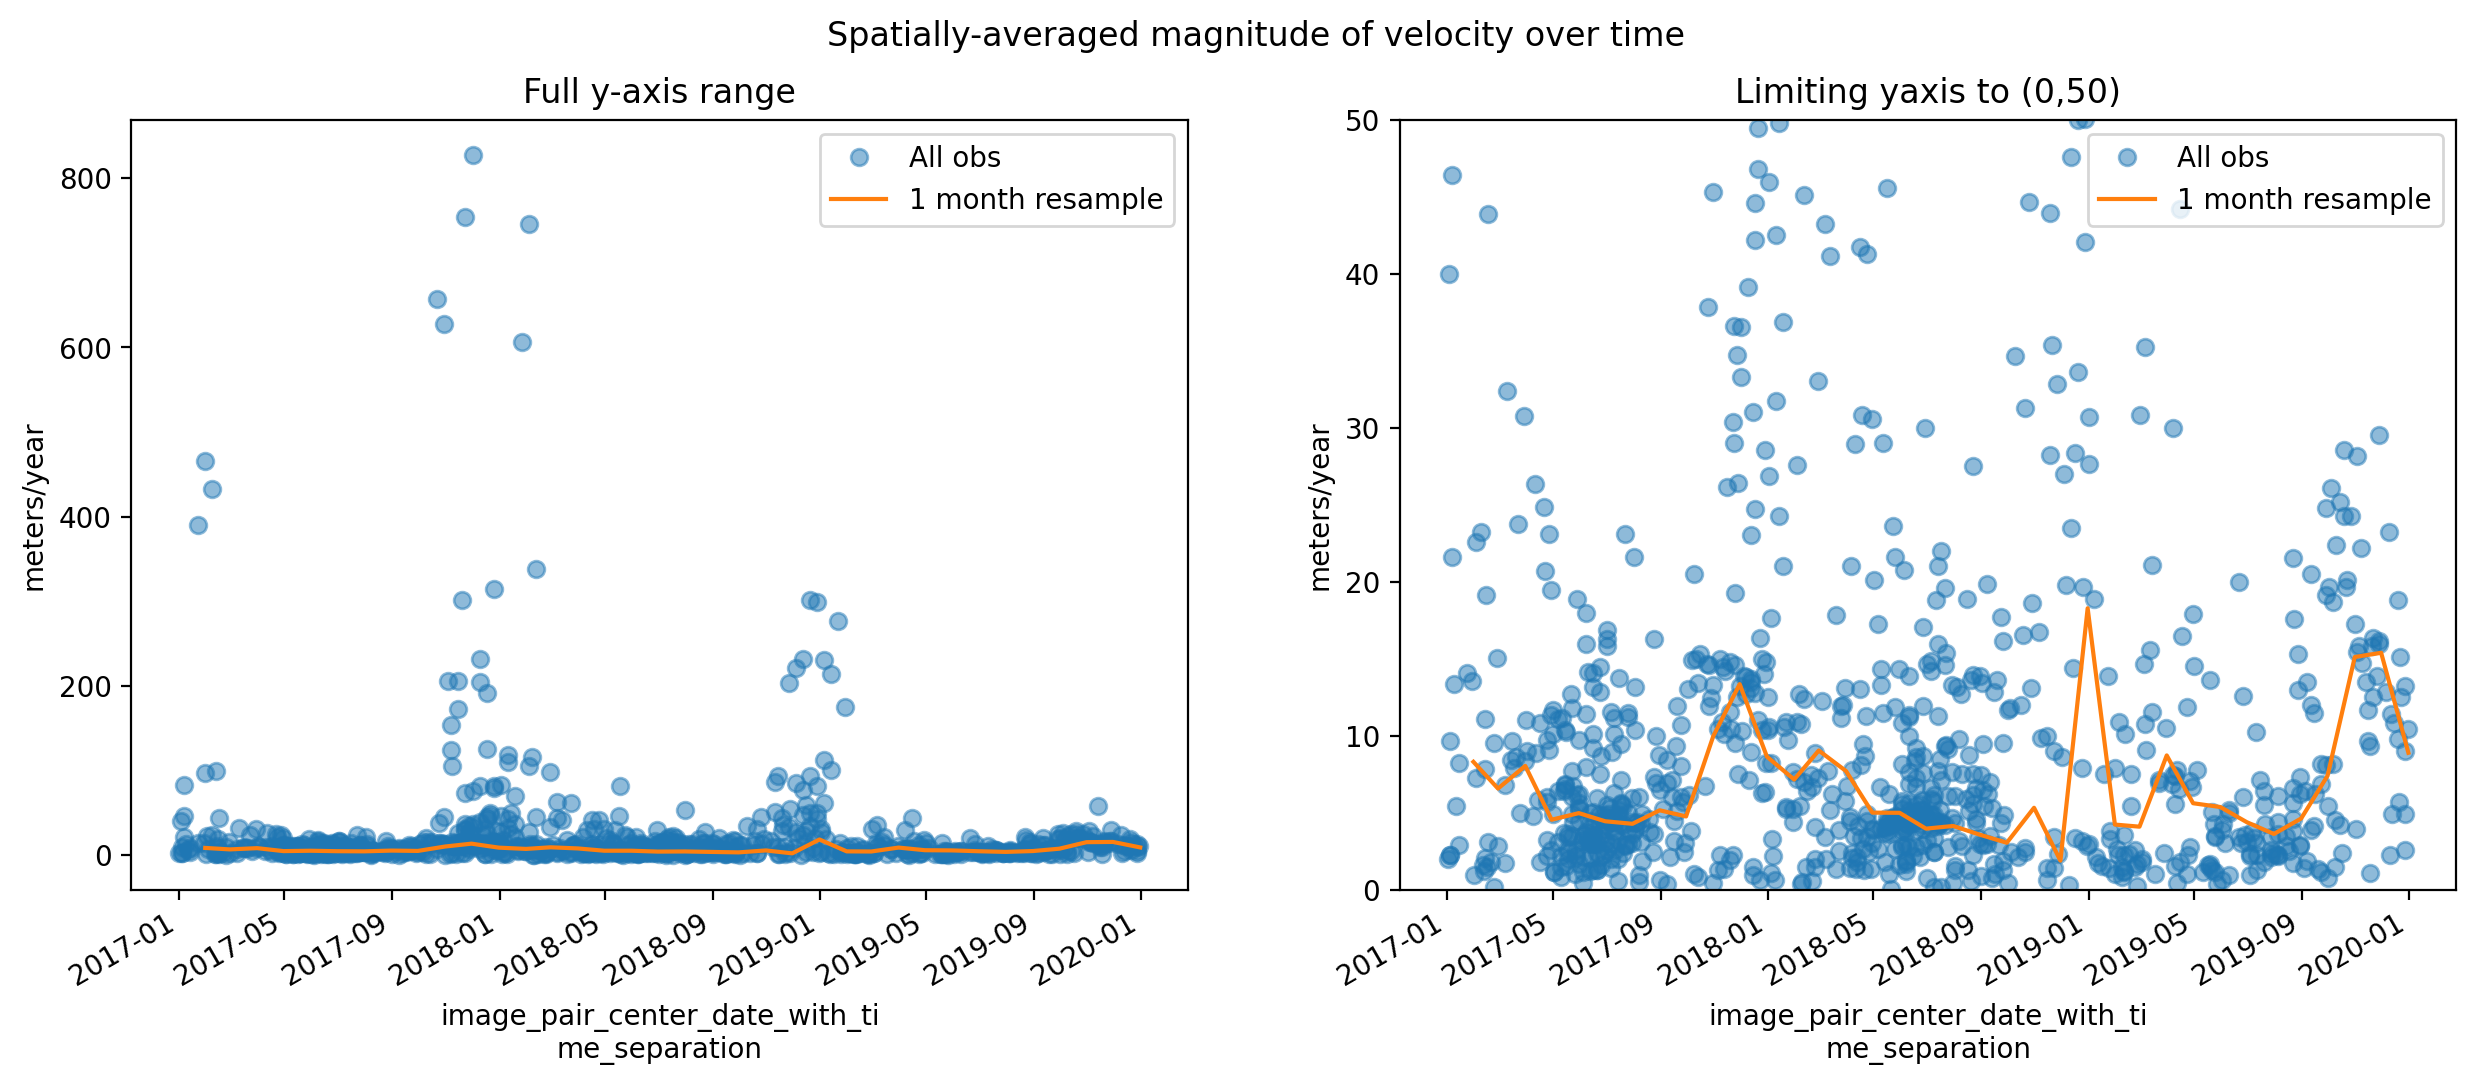

In [22]:
fig, (ax,ax1) = plt.subplots(ncols=2, figsize=(15,5))

raw_kwargs = {'linewidth': 0,
          'marker':'o',
          'alpha':0.5}


fig.suptitle('Spatially-averaged magnitude of velocity over time')
calc_velocity_magnitude(sample_glacier_raster).v_mag_time.plot(label = 'All obs',ax=ax, **raw_kwargs)
calc_velocity_magnitude(glacier_resample_1mo).v_mag_time.plot(label = '1 month resample',ax=ax)
ax.legend()
ax.set_ylabel('meters/year')
ax.set_title('Full y-axis range')

calc_velocity_magnitude(sample_glacier_raster).v_mag_time.plot(label = 'All obs',ax=ax1, **raw_kwargs)
calc_velocity_magnitude(glacier_resample_1mo).v_mag_time.plot(label = '1 month resample',ax=ax1)
ax1.legend()
ax1.set_ylabel('meters/year')
ax1.set_title('Limiting yaxis to (0,50)')
ax1.set_ylim(0,50);

This is interesting - despite what looks to be a pretty noisy signal looking at the full time series, we can start to pick out a seasonal signal and sub-annual velocity variability looking at the velocity data resampled into 1-month bins.

## Calculating velocity anomalies

To do this, we will use xarray `.groupby()` and `.map()` 


following example from xarray tutorial

We first define a function that subtracts the long-term mean from a single observation. 

In [24]:
def remove_time_mean(x):
    return x-x.mean(dim='mid_date')

We then group the dataset by month and apply the function to calculate the anomaly on each group. Because we are using the anomalies of the velocity component vectors we will calculate the mean:

In [25]:
glacier_anom = sample_glacier_raster.groupby('mid_date.month').map(remove_time_mean)

We can visualize the anomalies of the x and y-components of velocity averaged over the glacier surface over time (below). Note that if we tried to compute the magnitude of velocity anomalies, they would all be positive because magnitude is a scalar quantity. Thus, this would show us the magnitude of the anomaly's deviation from the mean but not the direction. To discern whether a magnitude of velocity anomaly is positive or negative, we would need to examine the signs of the velocity component anomalies. For simplicity, this demonstration will focus on the component anomalies. 

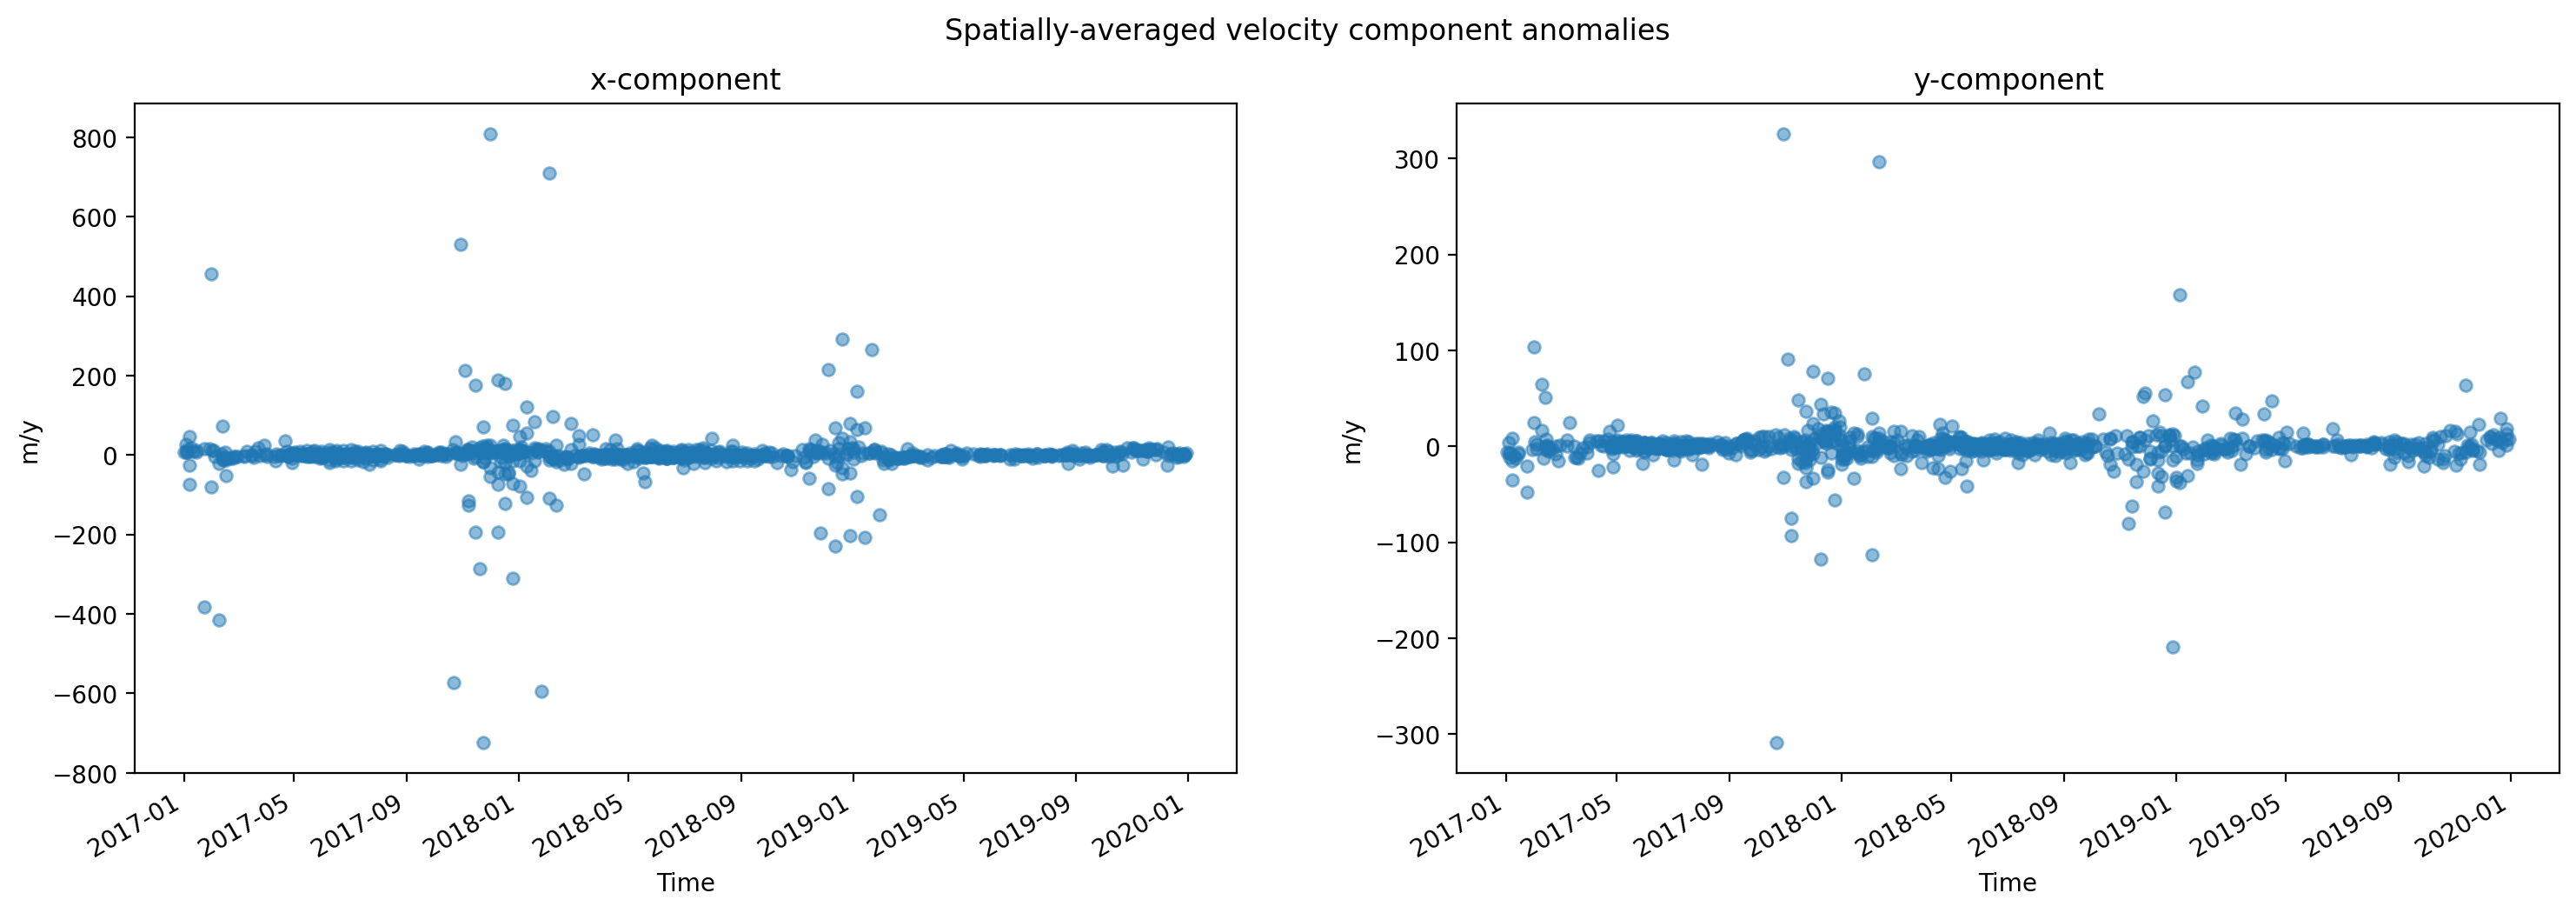

In [149]:
fig, ax = plt.subplots(ncols=2, figsize=(18,5))
glacier_anom.mean(dim=['x','y']).vx.plot(ax=ax[0], marker='o', linewidth=0, markersize=5, alpha=0.5)
glacier_anom.mean(dim=['x','y']).vy.plot(ax=ax[1], marker='o', linewidth=0, markersize=5, alpha=0.5)

ax[0].set_title('x-component')
ax[1].set_title('y-component')
ax[0].set_ylabel('m/y')
ax[1].set_ylabel('m/y')
ax[0].set_xlabel('Time')
ax[1].set_xlabel('Time')

fig.suptitle('Spatially-averaged velocity component anomalies');

## Grouped analysis by season
We have a dense time series of surface velocity data for a single glacier. We can use xarray's `.groupby()` to examine velocity variability further. We will start with using `.groupby()` to break the velocity time series into seasonal means.

In [150]:
seasons_gb = sample_glacier_raster.groupby(sample_glacier_raster.mid_date.dt.season).mean()
#add attrs to gb object
seasons_gb.attrs = sample_glacier_raster.attrs 
seasons_gb

<xarray.Dataset>
Dimensions:                     (season: 4, y: 37, x: 40)
Coordinates:
  * x                           (x) float64 7.843e+05 7.844e+05 ... 7.889e+05
  * y                           (y) float64 3.316e+06 3.316e+06 ... 3.311e+06
    mapping                     int64 0
  * season                      (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables: (12/49)
    M11                         (season, y, x) float32 nan nan nan ... nan nan
    M11_dr_to_vr_factor         (season) float32 nan nan nan nan
    M12                         (season, y, x) float32 nan nan nan ... nan nan
    M12_dr_to_vr_factor         (season) float32 nan nan nan nan
    chip_size_height            (season, y, x) float32 nan nan nan ... nan nan
    chip_size_width             (season, y, x) float32 nan nan nan ... nan nan
    ...                          ...
    vy_error_slow               (season) float32 17.09 9.745 12.29 20.32
    vy_error_stationary         (season) float32 17.1 9.746 12.29 20.32
    vy_stable_shift             (season) float32 3.759 -4.472 0.4827 3.443
    vy_stable_shift_slow        (season) float32 3.767 -4.477 0.4903 3.428
    vy_stable_shift_stationary  (season) float32 3.759 -4.472 0.4827 3.443
    cov                         (season) float64 0.1257 0.1471 0.08793 0.1125
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               25-Sep-2023 22:00:23
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

Breaking down the above cell, we defined how we wanted to group our data (`sample_glacier_raster.mid_date.dt.season`) and the reduction we wanted to apply to each group (`mean()`). After the apply step, xarray automatically combines the groups into a single object. We can see that the `seasons_gb` object is an `xarray.Dataset` with the same dimensions and coordinates as the `sample_glacier_raster` object but that the `seasons_gb` object has a `seasons` dimension as well.

 If you'd like to see another example of this with more detailed explanations, go [here](https://tutorial.xarray.dev/fundamentals/03.2_groupby_with_xarray.html).

We can no longer use the function for calculating magnitude that we defined above because we have the `season` dimension instead of `mid_date`. Because the temporal reduction has already occurred, we just need to calculate the magnitude of the displacement vector.

In [151]:
seasons_gb['v_mag'] = np.sqrt(seasons_gb.vx**2 + seasons_gb.vy**2)

In [152]:
seasons_gb

<xarray.Dataset>
Dimensions:                     (season: 4, y: 37, x: 40)
Coordinates:
  * x                           (x) float64 7.843e+05 7.844e+05 ... 7.889e+05
  * y                           (y) float64 3.316e+06 3.316e+06 ... 3.311e+06
    mapping                     int64 0
  * season                      (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables: (12/50)
    M11                         (season, y, x) float32 nan nan nan ... nan nan
    M11_dr_to_vr_factor         (season) float32 nan nan nan nan
    M12                         (season, y, x) float32 nan nan nan ... nan nan
    M12_dr_to_vr_factor         (season) float32 nan nan nan nan
    chip_size_height            (season, y, x) float32 nan nan nan ... nan nan
    chip_size_width             (season, y, x) float32 nan nan nan ... nan nan
    ...                          ...
    vy_error_stationary         (season) float32 17.1 9.746 12.29 20.32
    vy_stable_shift             (season) float32 3.759 -4.472 0.4827 3.443
    vy_stable_shift_slow        (season) float32 3.767 -4.477 0.4903 3.428
    vy_stable_shift_stationary  (season) float32 3.759 -4.472 0.4827 3.443
    cov                         (season) float64 0.1257 0.1471 0.08793 0.1125
    v_mag                       (season, y, x) float32 nan nan nan ... nan nan
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               25-Sep-2023 22:00:23
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

Reorder the seasons:

In [153]:
seasons_gb=seasons_gb.reindex({'season':['DJF','MAM','JJA','SON']})

To visualize velocity data across the seasonal groups we just defined, we can use xarray's `FacetGrid` functionality. Faceting is a great way to visualize your data in 'small multiples' format. 

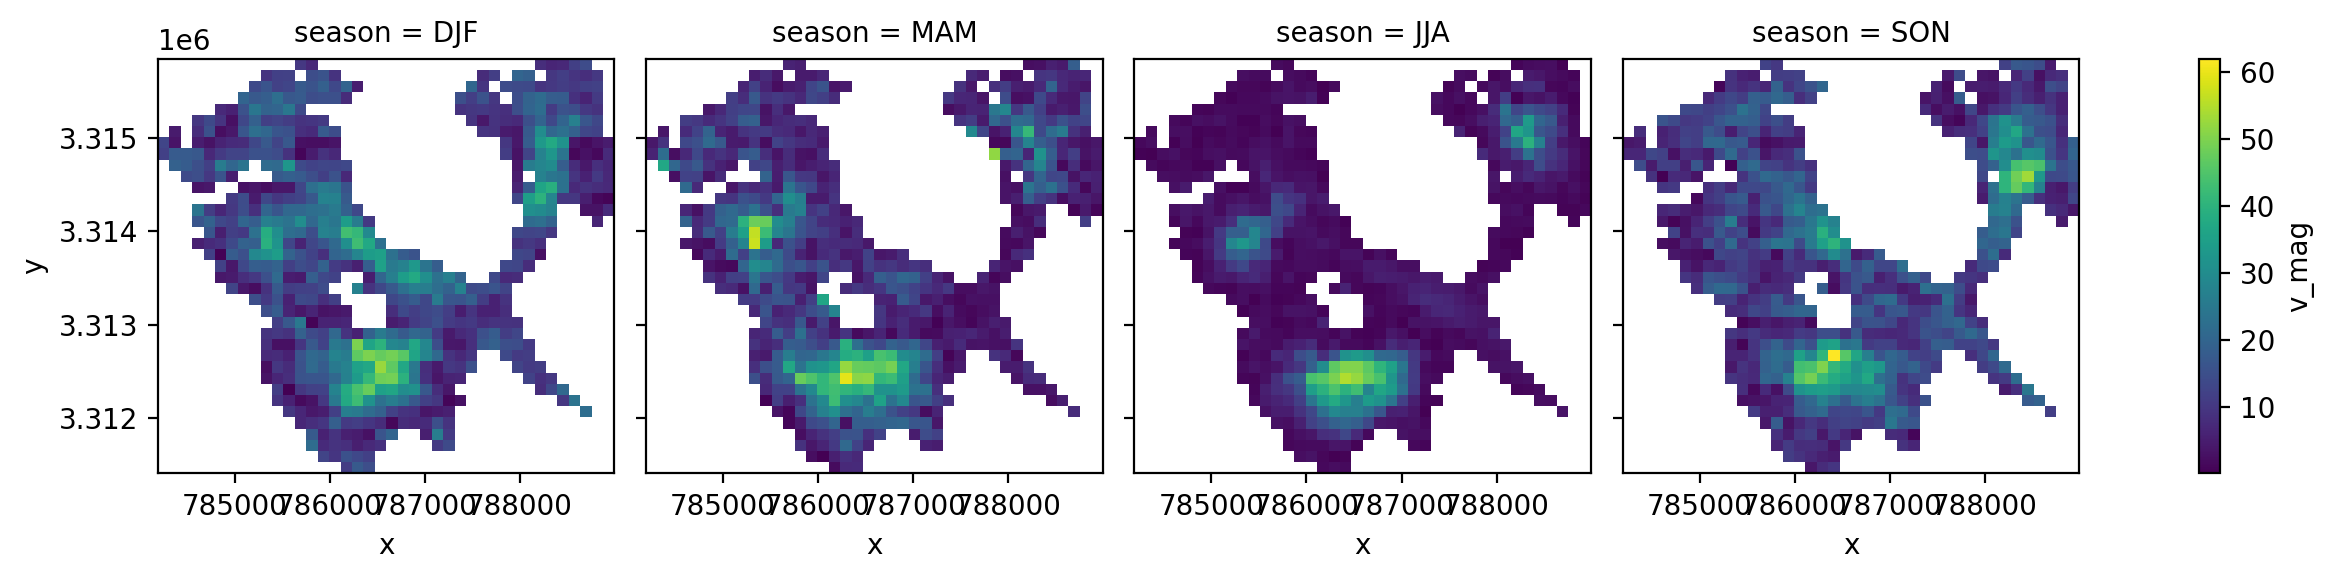

In [154]:
fg = seasons_gb.v_mag.plot(
    col='season',
);

What if we wanted to do the same grouping over years?

In [155]:
years_gb = sample_glacier_raster.groupby(sample_glacier_raster.mid_date.dt.year).mean()
years_gb.attrs = sample_glacier_raster.attrs 
years_gb['v_mag'] = np.sqrt(years_gb.vx**2 + years_gb.vy**2)

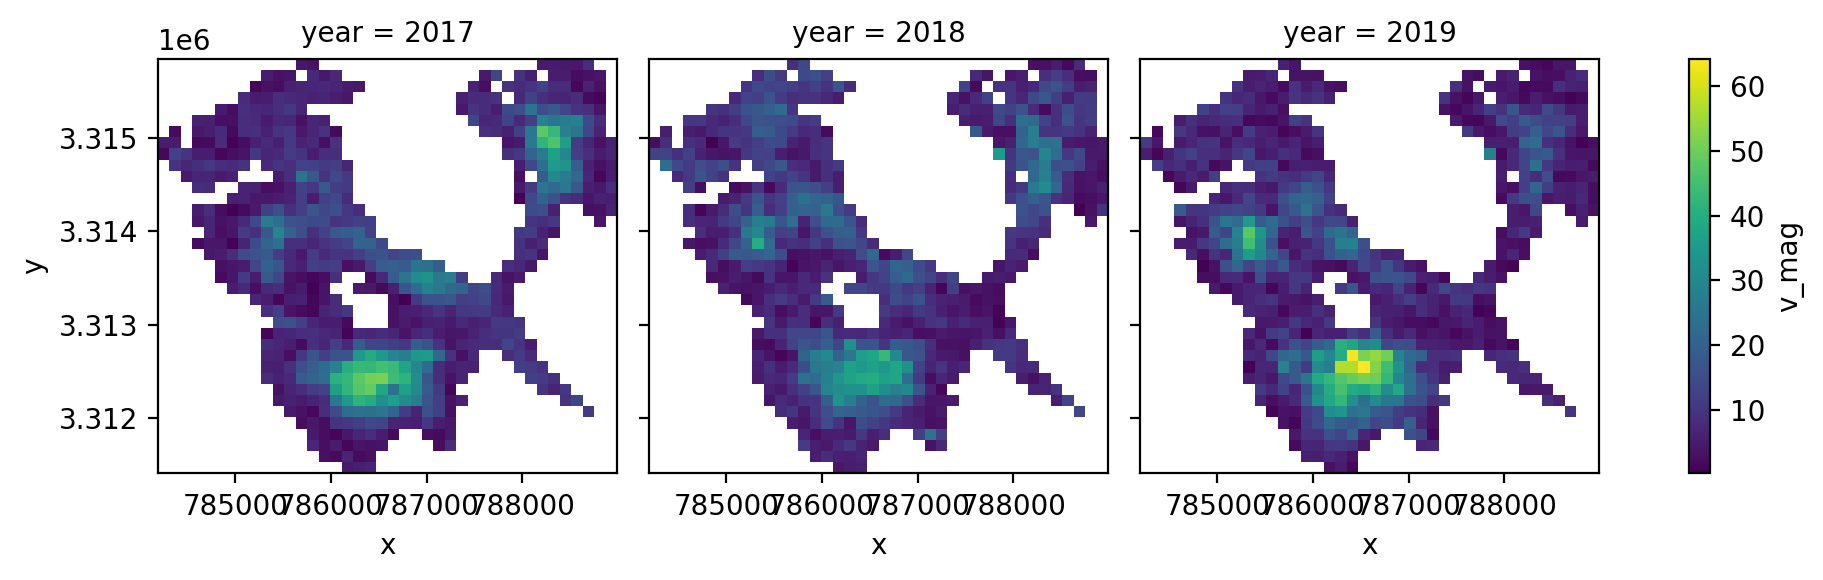

In [156]:
fg_years = years_gb.v_mag.plot(col='year');

We can also reduce the grouped object over space:

In [157]:
seasons_gb['v_mag_season'] = np.sqrt(seasons_gb.vx.mean(dim=['x','y'])**2 + seasons_gb.vy.mean(dim=['x','y'])**2)

Let's plot the mean magnitude of velocity for each season:

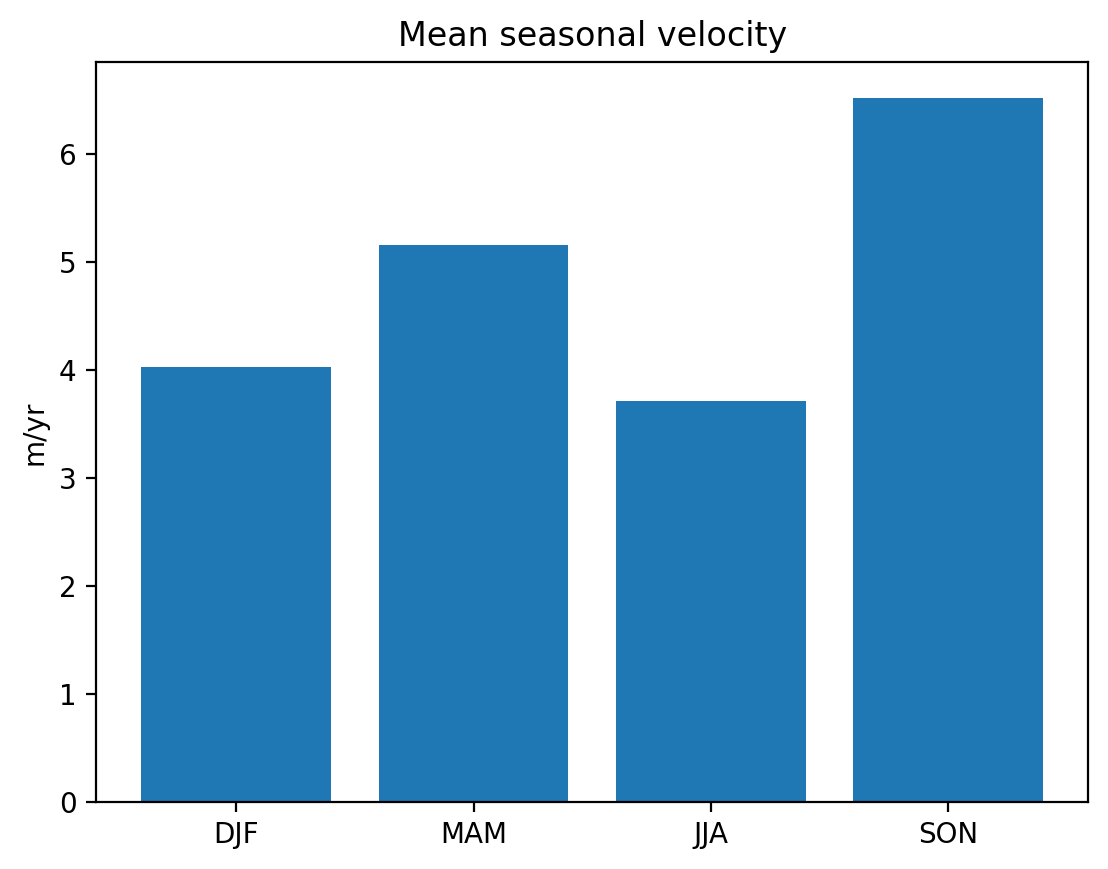

In [158]:
fig, ax = plt.subplots()
ax.bar(height = seasons_gb['v_mag_season'].data, x = seasons_gb['v_mag_season'].season.data)
ax.set_ylabel('m/yr')
ax.set_title('Mean seasonal velocity');

## Extracting and visualizing data at a single point

We can use xarray's `.sel()` to extract velocity data at a single point or within a subset along given dimensions. In this example, we use `.sel()` to compare the magnitude of velocity of ice flow at a point in the glacier's accumulation zone to the mean magnitude of velocit of the entire glacier. 

In [159]:
#choose coordinates for a point
y = 3.3125e6
x = 786500

In [160]:
point_v_resample = np.sqrt(glacier_resample_1mo.sel(x=x,y=y,method='nearest').vx**2 + glacier_resample_1mo.sel(x=x,y=y,method='nearest').vy**2)
point_v = np.sqrt(sample_glacier_raster.sel(x=x,y=y,method='nearest').vx**2 + sample_glacier_raster.sel(x=x,y=y,method='nearest').vy**2)

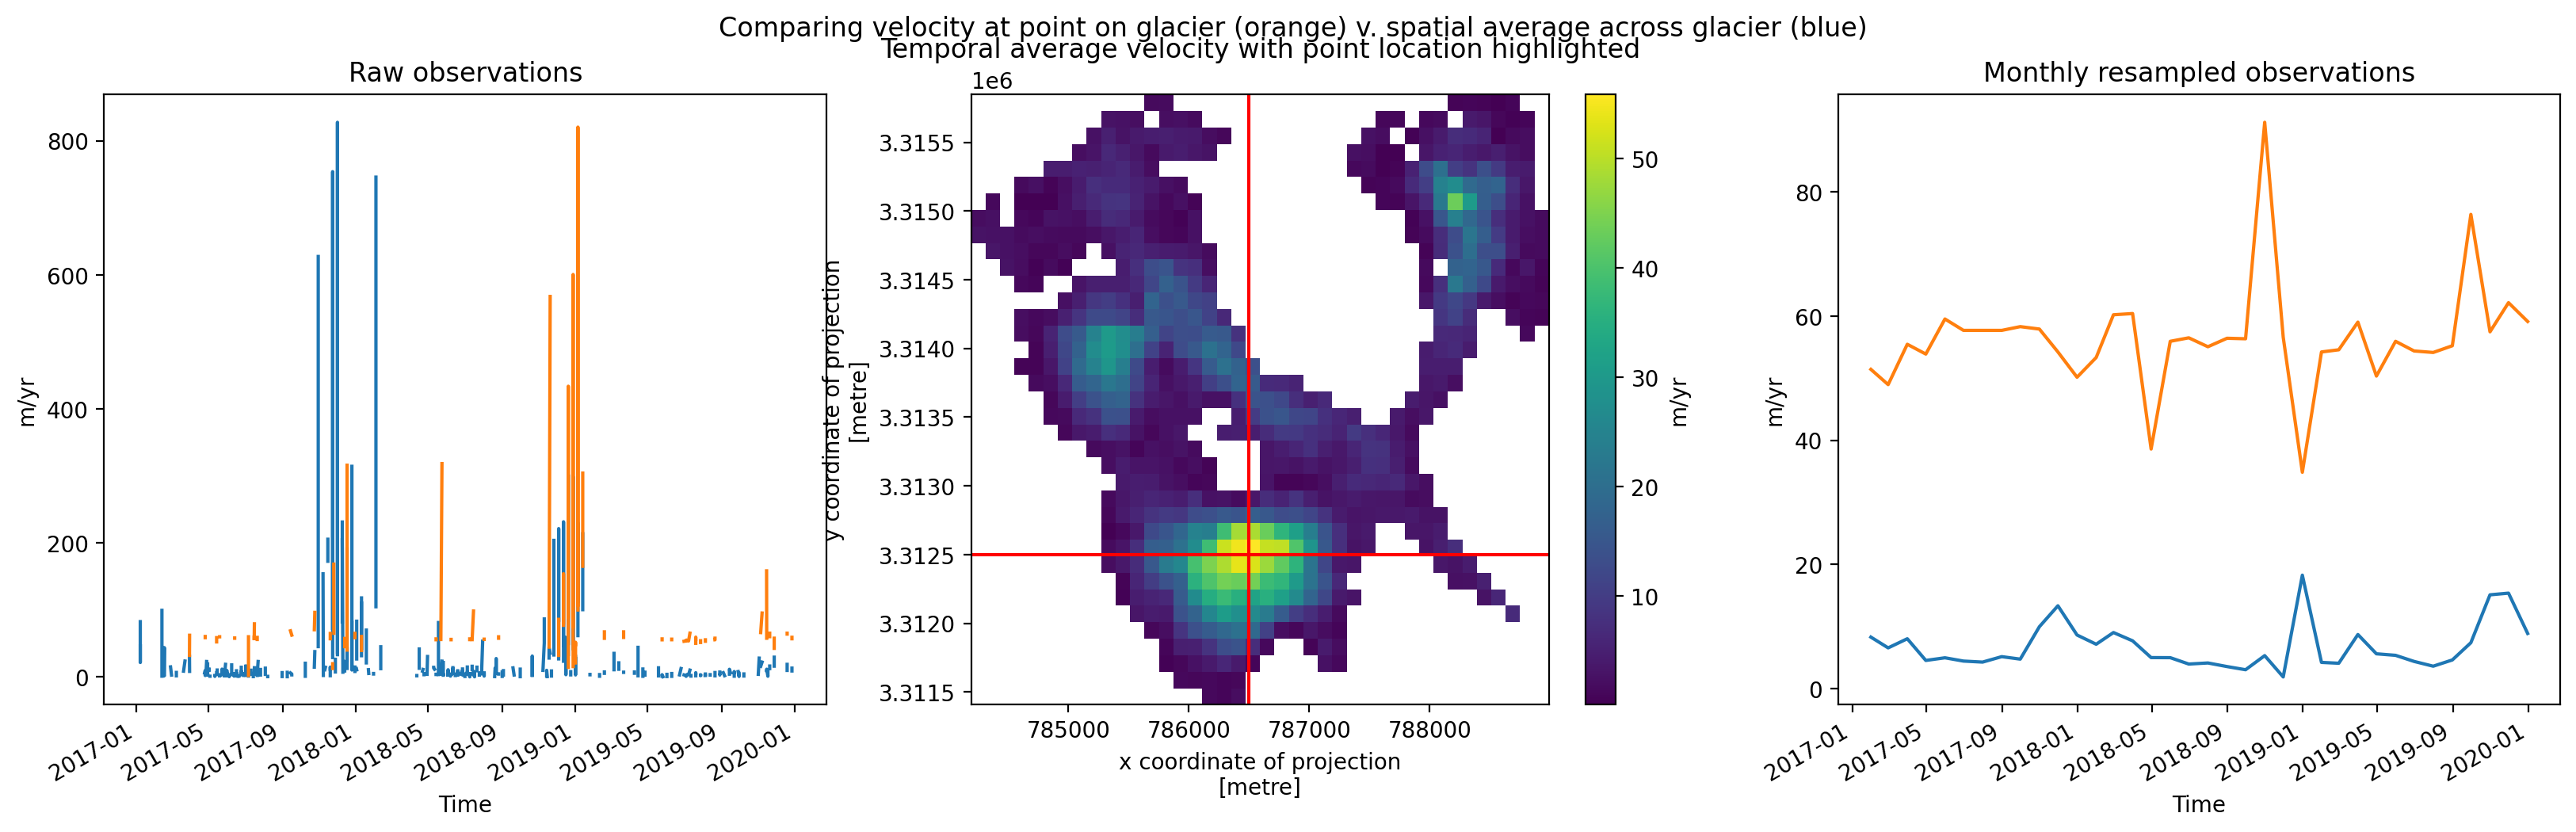

In [161]:
# ax1:
fig,axs=plt.subplots(ncols=3, figsize=(20,5))
#plot raw (not resampled data)
calc_velocity_magnitude(sample_glacier_raster).v_mag_time.plot(ax=axs[0])
point_v.plot(ax=axs[0])
#plot temporal mean and point location
b = calc_velocity_magnitude(glacier_resample_1mo).v_mag_space.plot(ax=axs[1])
axs[1].axvline(x=x, c= 'red')
axs[1].axhline(y=y, c='red')

# spatial mean average velocity over time
calc_velocity_magnitude(glacier_resample_1mo).v_mag_time.plot(ax=axs[2])
# point velocity over time
point_v_resample.plot(ax=axs[2])

fig.suptitle('Comparing velocity at point on glacier (orange) v. spatial average across glacier (blue)')
axs[0].set_title('Raw observations')
axs[1].set_title('Temporal average velocity with point location highlighted')
axs[2].set_title('Monthly resampled observations')

axs[0].set_ylabel('m/yr')
axs[2].set_ylabel('m/yr')
axs[0].set_xlabel('Time')
axs[2].set_xlabel('Time')
b.colorbar.set_label('m/yr');

### Conclusion

This notebook demonstrated trimming a full ITS_LIVE granule down to the spatial extent of a single glacier outline. We then worked through some statistical investigation of the data and preliminary data visualization steps. The next notebook will look at grouped analysis of multiple glaciers.